In [1]:
!pip install autogluon
!pip install --upgrade ipykernel

     |████████████████████████████████| 273 kB 1.1 MB/s 
     |████████████████████████████████| 56 kB 2.9 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 352 kB 11.9 MB/s 
     |████████████████████████████████| 4.2 MB 36.3 MB/s 
     |████████████████████████████████| 206 kB 58.8 MB/s 
     |████████████████████████████████| 1.3 MB 30.3 MB/s 
     |████████████████████████████████| 119 kB 36.6 MB/s 
     |████████████████████████████████| 3.0 MB 28.3 MB/s 
     |████████████████████████████████| 186 kB 67.5 MB/s 
     |████████████████████████████████| 67.3 MB 19 kB/s 
     |████████████████████████████████| 157 kB 46.6 MB/s 
     |████████████████████████████████| 90 kB 5.7 MB/s 
     |████████████████████████████████| 1.2 MB 30.4 MB/s 
     |████████████████████████████████| 2.9 MB 25.4 MB/s 
     |████████████████████████████████| 377 kB 41.6 MB/s 
     |████████████████████████████████| 243 kB 60.9 MB/s 
     |████████████████

In [2]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from sklearn.metrics import f1_score, roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from sklearn.calibration import CalibratedClassifierCV

# Imports from our package
from autogluon.tabular import TabularPredictor

# Everything for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('../input/porto-seguro-data-challenge/train.csv', index_col='id').reset_index(drop=True)
test = pd.read_csv('../input/porto-seguro-data-challenge/test.csv', index_col='id').reset_index(drop=True)
sample_submission = pd.read_csv('../input/porto-seguro-data-challenge/submission_sample.csv')
meta = pd.read_csv('../input/porto-seguro-data-challenge/metadata.csv')

cat_nom = [x for x in meta.iloc[1:-1, :].loc[(meta.iloc[:,1]=="Qualitativo nominal")].iloc[:,0]] 
cat_ord = [x for x in meta.iloc[1:-1, :].loc[(meta.iloc[:,1]=="Qualitativo ordinal")].iloc[:,0]] 
num_dis = [x for x in meta.iloc[1:-1, :].loc[(meta.iloc[:,1]=="Quantitativo discreto")].iloc[:,0]] 
num_con = [x for x in meta.iloc[1:-1, :].loc[(meta.iloc[:,1]=="Quantitativo continua")].iloc[:,0]] 

In [4]:
train.loc[:, 'xgb_shap_autogluon'] = pd.read_csv('../input/porto-seguro-autogluon-shap/autogluon_oof.csv').autogluon_shap_oof
test.loc[:, 'xgb_shap_autogluon'] = pd.read_csv('../input/porto-seguro-autogluon-shap/autogluon_shap_sub_probs.csv').predicted

train.loc[:, 'xgb_shap_cat_knn'] = pd.read_csv('../input/porto-seguro-catboost-knn-shap/cat_oof.csv').cat_shap_oof
test.loc[:, 'xgb_shap_cat_knn'] = pd.read_csv('../input/porto-seguro-catboost-knn-shap/cat_shap_sub_probs.csv').predicted

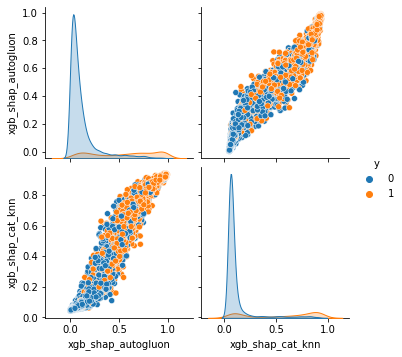

In [5]:
sns.pairplot(train[['xgb_shap_autogluon', 'xgb_shap_cat_knn', 'y']], hue="y");

In [6]:
# Create new features
for data in [train, test]:
    data['xgb_shap_autogluon_minus_xgb_shap_cat_knn'] = data['xgb_shap_autogluon'] - data['xgb_shap_cat_knn']
    data['xgb_shap_autogluon_mul_xgb_shap_cat_knn']   = data['xgb_shap_autogluon'] * data['xgb_shap_cat_knn']
    data['xgb_shap_autogluon_div_xgb_shap_cat_knn']   = data['xgb_shap_autogluon'] / data['xgb_shap_cat_knn']

In [7]:
K=10
SEED=25
kf = KFold(n_splits=K, random_state=SEED, shuffle=True)

In [8]:
def get_threshold(y_true, y_pred):
    # Moving threshold
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = []
    for thresh in thresholds:
        f1_scores.append(
            f1_score(y_true, [1 if m>thresh else 0 for m in y_pred]))
    f1s = np.array(f1_scores)
    return thresholds[f1s.argmax()]
    
    
def custom_f1(y_true, y_pred):
     
    max_f1_threshold =  get_threshold(y_true, y_pred)

    y_pred = np.where(y_pred>max_f1_threshold, 1, 0)
    f1_after = f1_score(y_true, y_pred) 
    
    return f1_after

# AutoGluon
---

In [9]:
predictor = TabularPredictor(label="y",
                             problem_type='binary',
                             eval_metric="log_loss",
                             path='./AutoGlon/',
                             verbosity=1)

predictor.fit(train, presets='best_quality', time_limit=60*60*7.5)

results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val      fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3  -0.296765     105.708206  17372.340611                0.001522           2.081193            3       True         26
1      LightGBMLarge_BAG_L2  -0.297128     103.377160  16875.315897                1.830949        1630.584342            2       True         25
2           LightGBM_BAG_L2  -0.297851     103.031022  15745.402995                1.484810         500.671439            2       True         16
3            XGBoost_BAG_L2  -0.298019     103.875736  15739.675077                2.329524         494.943521            2       True         23
4       WeightedEnsemble_L2  -0.300266      71.935567   6206.642608                0.001494           2.403847            2       True         14
5           CatBoost_BAG_L1  -0.300409       1.795223    635.2

In [10]:
y_oof = predictor.get_oof_pred_proba().iloc[:,1]
y_pred = predictor.predict_proba(test).iloc[:,1]

In [11]:
final_threshold = get_threshold(train.y, y_oof)
final_threshold

0.36

In [12]:
print("Final F1     :", custom_f1(train.y, y_oof))
print("Final AUC    :", roc_auc_score(train.y, y_oof))
print("Final LogLoss:", log_loss(train.y, y_oof))

Final F1     : 0.6872727272727273
Final AUC    : 0.8982496292180822
Final LogLoss: 0.2967651072509729


# Sub
---

In [13]:
# Write predictions to sub
sample_submission['predicted'] = np.where(y_pred>final_threshold, 1, 0).astype('int64')
sample_submission.to_csv('autogluon_pseudo_sub.csv',index=False)

In [14]:
# Write predictions to stack
sample_submission['predicted'] = y_pred

sample_submission.to_csv('autogluon_pseudo_sub_probs.csv',index=False)
pd.DataFrame({'id':train.index, 'autogluon_pseudo_oof':y_oof}).to_csv('autogluon_pseudo_oof.csv',index=False)

In [15]:
import shutil
shutil.rmtree('./AutoGlon/')